In [1]:
import numpy as np
import matplotlib.pyplot as plt

import camb
from scipy.interpolate import interp1d


# Creating Target Power Spectrum

First, we create a target power spectrum. We set cosmological parameters and use CAMB to generate the linear power spectrum at the desired redshift.
Then, we interpolate over it.

In [51]:
Omega_b= 0.05
Omega_c = 0.25

h = 0.7
As = 2.1e-9
ns =0.96

pars=camb.CAMBparams()
pars.set_cosmology(H0=100*h, ombh2=Omega_b*h**2, omch2=Omega_c*h**2)
pars.InitPower.set_params(As=As, ns=ns);

pars.set_matter_power(redshifts=[10.], kmax=100.);

In [52]:
result = camb.get_results(pars)

In [54]:
kh, z, pk = result.get_matter_power_spectrum(minkh=1.e-4, maxkh=100, npoints=512)

Text(0, 0.5, '$P(k) [h^{-3} \\mathrm{Mpc}^3]$')

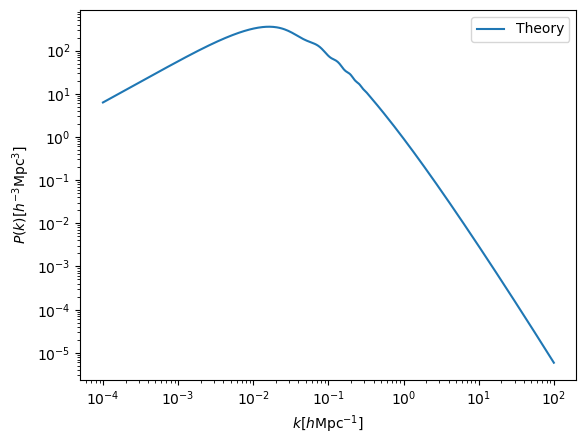

In [55]:
plt.loglog(kh, pk[0], label="Theory")
plt.legend(loc="best")
plt.xlabel(r"$k [h \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$P(k) [h^{-3} \mathrm{Mpc}^3]$")

In [56]:
# Create an interpolator for the power spectrum

pk_interpolate = interp1d(kh, pk[0], kind="cubic", fill_value="extrapolate")

# Create the Grid

We now create the grid, in Fourier Space, to compute $\delta(k)$.

To do so, we require at least two quantities:

* the box size
* the cell size

We set box side 500 Mpc and cell size = 5 Mpc.

Our grid will then have $100^3$ cells.

In [59]:
side = 500 
Volume = side**3

spacing = 5
n_cells = side//spacing

print(n_cells)

100


We compute fundamental mode of the box $k_F$ and the Nyquist frequency $k_N$.

In [61]:
kF = 2*np.pi/side
kN = 2*np.pi/spacing

print("kF = ", kF, "1/Mpc;", "kN = ", kN, "1/Mpc")            

kF =  0.012566370614359173 1/Mpc; kN =  1.2566370614359172 1/Mpc


We now set the grid points in k-space

In [73]:
kx = np.fft.fftfreq(n_cells, spacing)*np.pi*2
ky = np.fft.fftfreq(n_cells, spacing)*np.pi*2
kz = np.fft.rfftfreq(n_cells, spacing)*np.pi*2

print(kx.shape, ky.shape, kz.shape)


(100,) (100,) (51,)


In [74]:
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing="xy")

After setting the grid, we proceed with the computation of the random density field.

1. Compute the $P(K)$ at each step of the grid;
2. Generate a random phase $0 < \phi <2\pi$;
3. Generate a random norm. The norm is extract from $\mathcal{N}(0, \sqrt{P(k)\cdot V})$;
4. Convert to configuration space via inverse real FFT. 


In [75]:
# Step #1: Compute the norm of the wavevector and the corresponding Power spectrum

knorm = np.sqrt(KX**2 + KY**2 + KZ**2)
pks = pk_interpolate(knorm)

In [77]:
# Step #2: Generate Random delta(k) phase

phase = np.random.uniform(size=pks.shape)*2*np.pi

In [78]:
# Step #3: Generate random delta(k) norm

delta_k_norm = np.random.normal(size=pks.shape) * np.sqrt(pks * Volume)


delta_k_norm[0,0,0]=0

In [79]:
delta_k = delta_k_norm * (np.cos(phase)  + 1j * np.sin(phase))

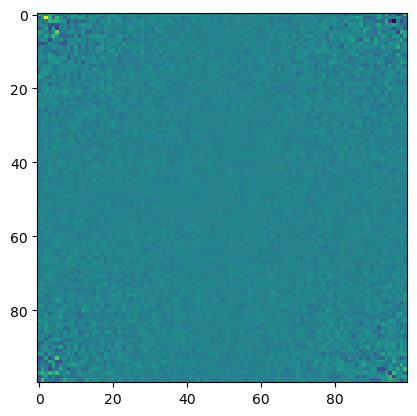

In [80]:
plt.imshow(delta_k_norm[:, :, 2])

In [28]:
# Step 4: Compute the inverse Fourier transform of delta(k)

# Please notice that irfftn with "backward" normalization means that the inverse Fourier transform is normalized by the number of cells
# Further dividing by spacing**3 we get the density contrast in the real space, normalized by the volume of the box.

delta_x = np.fft.irfftn(delta_k, norm="backward")/spacing**3

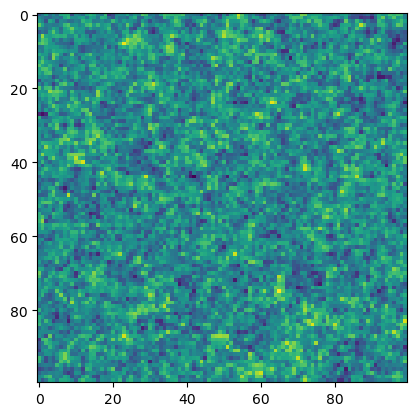

In [81]:
plt.imshow(delta_x[:, :, 2])

Text(0.5, 0, '$\\delta(x)$')

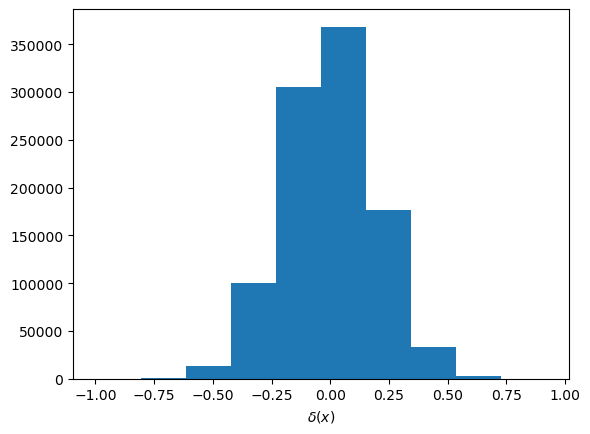

In [82]:
plt.hist(delta_x.flatten())
plt.xlabel(r"$\delta(x)$")

In [84]:
print("The mean of the density field is:", np.mean(delta_x))

The mean of the density field is: 2.0605739337042906e-19


# Extract Power spectrum

Let's now measure the power spectrum, and verify that it is consistent with the input power spectrum.

In [85]:
# Compute the squared density field
delta_k_sq = np.abs(delta_k)**2

In [87]:
# Compute the power spectrum per cell
pks = delta_k_sq.flatten()/Volume

Text(0, 0.5, '$P(k) [h^{-3} \\mathrm{Mpc}^3]$')

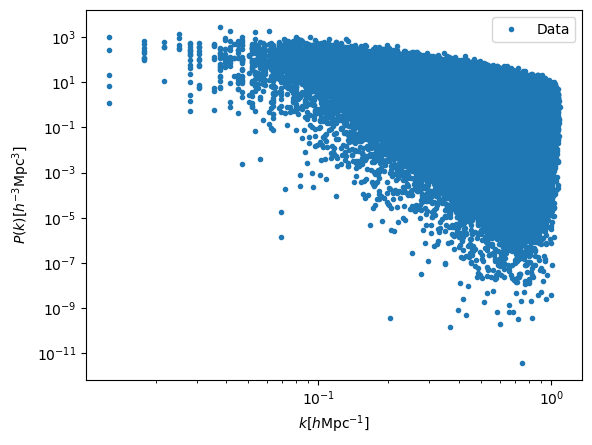

In [89]:
# Plot

plt.loglog(knorm.flatten(), pks, ".", label="Data")

plt.legend(loc="best")
plt.xlabel(r"$k [h \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$P(k) [h^{-3} \mathrm{Mpc}^3]$")

Let's average over wavebands

1. Define a binning
2. Average power spectrum values accumulated by the value of the wavevector norm

In [90]:
# Binning
edges = np.arange(kF, kN, kF)
k_bin = (edges[1:]+edges[0:-1])/2

In [91]:
pk_meas = np.zeros(len(edges)-1)

In [95]:
for i in range(len(k_bin)):
    k_selection = np.where((knorm.flatten()>edges[i]) & (knorm.flatten()<edges[i+1]))[0]
    pk_meas[i] = np.mean(pks[k_selection])

/home/alfonso/miniconda3/envs/acc-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/miniconda3/envs/acc-env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, '$P(k) [h^{-3} \\mathrm{Mpc}^3]$')

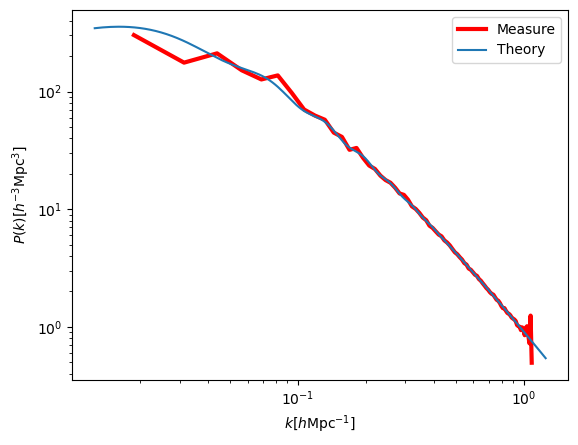

In [96]:
# Plot
plt.loglog(k_bin, pk_meas, "-", label="Measure", color="r", lw=3)
plt.loglog(kh[ (kh>kF) & (kh<kN)], pk[0][ (kh>kF) & (kh<kN)], label="Theory")

plt.legend(loc="best")
plt.xlabel(r"$k [h \mathrm{Mpc}^{-1}]$")
plt.ylabel(r"$P(k) [h^{-3} \mathrm{Mpc}^3]$")

# Next on the list

1. Generate LogNormal Power spectrum
2. Insert in pyACC as a new package

# Generate LogNormal Density field

1. Set the Power Spectrum;
2. Put the Power Spectrum on the grid;
3. Transform to Correlation function with fft;
4. Compute $\xi_G = \log(1+\xi(\vec{r}))$ on the grid;
5. Convert it back to Fourier Space to obtain $P_G(k)$;
6. Generate Gaussian Random field $G(\vec{x})$ as before;
7. Apply lognormal transformation: 
   $$ \delta(\vec{x}) = \exp(-\sigma^2_g + G(\vec{x})) - 1 $$